# Big Data Platform
## Assignment 3: ServerLess

**The goal of this assignment is to:**
- Understand and practice the details of Serverless

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of your team.
- Your solution is in the form of a Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented.
- Please answer all the questions and include all your code.
- You are expected to submit a clear and pythonic code.
- You can change functions signatures/definitions.

**Submission:**
- Submission of the homework will be done via Moodle by uploading (not Zip):
    - Jupyter Notebook
    - 2 Log files
    - Additional local scripts
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.
- Late submission won't be allowed.


- In case of identical code submissions - both groups will get a Zero.
- Some groups might be selected randomly to present their code.

**Requirements:**
- Python 3.6 should be used.
- You should implement the algorithms by yourself using only basic Python libraries (such as numpy,pandas,etc.)

<br><br><br><br>

**Grading:**
- Q0 - 10 points - Setup
- Q1 - 40 points - Serverless MapReduceEngine
- Q2 - 20 points - MapReduce job to calculate inverted index
- Q3 - 30 points - Shuffle

`Total: 100`

<br><br>

# Question 0
## Setup

1. Navigate to IBM Cloud and open a trial account. No need to provide a credit card
2. Choose IBM Cloud Object Storage service from the catalog
3. Create a new bucket in IBM Cloud Object Storage
4. Create credentials for the bucket with HMAC (access key and secret key)
5. Choose IBM Cloud Functions service from the catalog and create a service


#### Lithops setup
1. By using “git” tool, install master branch of the Lithops project from
https://github.com/lithops-cloud/lithops
2. Follow Lithops documentation and configure Lithops against IBM Cloud Functions and IBM Cloud Object Storage
3. Configure Lithops log level to be in DEBUG mode
4. Run Hello World example by using Futures API and verify all is working properly.


#### IBM Cloud Object Storage setup
1. Upload all the input CSV files that you used in homework 2 into the bucket you created in IBM Cloud Object Storage


<br><br><br>

In [ ]:
!pip install lithops

In [ ]:
from lithops import FunctionExecutor, Storage
import random
import numpy as np
import string
import sqlite3 as sql
import pandas as pd

In [ ]:
config = {'lithops': {'backend': 'ibm_cf', 'storage': 'ibm_cos', 'log_level': 'DEBUG',
                      'log_stream': 'ext://sys.stdout', 'log_filename': 'log.log'},
          'ibm_cf':  {'endpoint': 'https://eu-gb.functions.cloud.ibm.com',
                      'namespace': 'aviv.ples@post.idc.ac.il_dev',
                      'api_key': '1199a27f-b727-48d1-ae5c-8be6748cbc99:2gx2MG60xNWa2lfCCcrwSrfK48UCPyTmdUONnLi3PphS4Uf5S8fT673vLxV9VHA5'},
          'ibm_cos': {'storage_bucket': 'big-data',
                      'region': 'eu-gb',
                      'access_key': "6e237bf3f29743e09ca4a6e3a107c458",
                      'secret_key': "1e50677aac3a335db874ae173435ceda82b48b7bcc4b12bc"}}

In [ ]:
def hello(name):
    return 'Hello {}!'.format(name)

with FunctionExecutor(config=config) as fexec:
    fut = fexec.call_async(hello, 'World')
    print(fut.result())

Hello World!


In [ ]:
random.seed(123)

def generate_random_name():
    """
    Generate a random name: First character is uppercase and
    alphabetic and the rest is series of lower case characters of length
    1 - 12. Giving us an output string of a length 2 - 13

    Returns:
    str: Randomly generated name
    """
    return random.choice(string.ascii_uppercase) + \
           ''.join(random.choices(string.ascii_lowercase, k=random.choice(range(1,12))))

In [ ]:
firstname = ['John', 'Dana', 'Scott', 'Marc', 'Steven', 'Michael', 'Albert', 'Johanna']
city = ['NewYork', 'Haifa', 'Munchen', 'London', 'PaloAlto',  'TelAviv', 'Kiel', 'Hamburg']
# Use list comprehension in order to create a list of 8 randomly generated names
secondname = [generate_random_name() for _ in range(8)] # please use some version of random

print(secondname)

['Bckcxa', 'Riweiigalc', 'Tbilxcdu', 'Axogvt', 'Kufpnvikun', 'Vqrxmrjate', 'Creikbloi', 'Gcqajfnsxqz']


In [ ]:
def generate_csvs(number_of_csvs):
    """
    Generate number_of_csvs csv files with 10 randomly generate rows for the
    defined columns by randomly picking a value from the lists of possible
    values for each column.

    Parameters:
    number_of_csvs (int): number of csv files to generate
    """
    for i in range(1,number_of_csvs+1):
        df = pd.DataFrame(columns=['firstname', 'secondname', 'city'])
        df['firstname'] = np.random.choice(firstname, 10)
        df['secondname'] = np.random.choice(secondname, 10)
        df['city'] = np.random.choice(city, 10)

        obj_key = f'myCSV{i}.csv'
        st = Storage(config=config)
        st.put_object(bucket='big-data', key=obj_key, body=df.to_csv(index=False))

In [ ]:
generate_csvs(20)

# Question 1
## Serverless MapReduceEngine

Modify MapReduceEngine from homework 2 into the MapReduceServerlessEngine where map and reduce tasks executed as a serverless actions, instead of local threads. In particular:
1. Deploy all map tasks as a serverless actions by using Lithops against IBM Cloud Functions.
2. Collect results from all map tasks and store them in the same SQLite as you used in MapReduceEngine and use the same code for the sort and shuffle phase.
3. Deploy reduce tasks by using Lithops against IBM Cloud Functions. Instead of persisting results from reduce tasks, return results back to the MapReduceServerlessEngine and proceed with the same workflow as in MapReduceEngine
4. Return results of reduce tasks to the user

**Please attach:**
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [ ]:
def create_connection(db_file):
    """
    Create an sql connection to the db by the given db file

    Parameters:
    db_file (str): Path of the db file to use to make a connection to the db

    Returns:
    conn (sql.Connection): Connection to db
    """
    conn = sql.connect(db_file)
    return conn

def create_table(conn, create_table_sql):
    """
    Create a table in the db with the given sql execution code

    Parameters:
    conn (sql.Connection): connection to db
    create_table_sql (str): sql execution code for table creation
    """
    c = conn.cursor()
    c.execute(create_table_sql)
    conn.commit()
    c.close()

In [ ]:
sql_create_table = """ CREATE TABLE IF NOT EXISTS temp_results (
                           key TEXT,
						   value TEXT
                           ); """

# create a database connection
sql_conn = create_connection("mydb.db")

# create table
create_table(sql_conn, sql_create_table)

In [ ]:
class MapReduceServerlessEngine():
    def execute(self, input_data, map_function, reduce_function):
        """
        Execute the mapreduce steps: map, shuffle and sort, reduce
        Parallelize the map and reduce steps by creating threads to run the
        map and reduce function in parallel on the partitioned data

        Parameters:
        input_data (dict): Dictionary to apply map_function on
        map_function: Map function to apply on input_data
        reduce_function: Reduce function on the shuffled and sorted output of
                         map_function

        Returns:
        str: Completion status message
        """

        # Start an exec for each key in input_data and run map_function on it
        with FunctionExecutor(config=config) as fexec:
            fexec.map(map_function, input_data)
            map_res = fexec.get_result()

        # Load content of all CSV files into temp_results table
        for df in map_res:
            df.to_sql('temp_results', sql_conn, if_exists='append', index=False)

        # SQL statement to generate a sorted list by key
        sql_generate_sorted_list = """
                                   SELECT key, GROUP_CONCAT(value)
                                   FROM temp_results
                                   GROUP BY key
                                   ORDER BY key;
                                   """
        sorted_list = sql_conn.execute(sql_generate_sorted_list).fetchall()

        # Start an exec for each value from the generated list
        with FunctionExecutor(config=config) as fexec:
            fexec.map(reduce_function, sorted_list)
            reduce_res = fexec.get_result()

        return reduce_res

In [ ]:
def inverted_map(obj):
    """
    Reads the csv document from the local disk and return a list that contains
    entries of the form (key_value, document name)

    Parameters:
    obj (csv): csv document name to run the map function on

    Returns:
    entries (DataFrame): DataFrame from tuples of the defined form
    """
    entries = []
    df = pd.read_csv(obj.data_stream)
    for _, row in df.iterrows():
        for col in df.columns:
            entries.append(("_".join([col, row[col]]), obj.key))
    res = pd.DataFrame(entries, columns=['key', 'value'])
    return res

def inverted_reduce(value, documents):
    """
    Take the two parameters given and put them together in a list and get rid of
    the duplicates in the parameter documents

    Parameters:
    value (str): column name and value in the form of columnname_value
    documents(str): list of all csv documents per given value

    Returns:
    DataFrame: concatenation of value and the list of csv documents with no duplicates
    """
    return pd.DataFrame([value] + list(set(documents.split(","))))

# Task 2
## Submit MapReduce job to calculate inverted index
1. Use input_data: `cos://bucket/<path to CSV data>`
2. Submit MapReduce job with reduce and map functions as you used in homework 2, as follows

    `mapreduce = MapReduceServerlessEngine()`
    `results = mapreduce.execute(input_data, inverted_map, inverted_index)`
    `print(results)`

**Please attach:**
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [ ]:
input_data = [f'cos://big-data/myCSV{i}.csv' for i in range(1,21)]

In [ ]:
mapreduce = MapReduceServerlessEngine()
res = mapreduce.execute(input_data, inverted_map, inverted_reduce)

# Question 3
## Shuffle

MapReduceServerlessEngine deploys both map and reduce tasks as serverless invocations.
However, once map stage completed, the result are transferred from the map tasks to the SQLite database located on the client machine (laptop in your case), then performed local shuffle and then invoked reduce tasks passing them relevant parameters.

(To support your answers, feel free to use examples, Images, etc.)
<br><br>

**1. Explain why this approach is not efficient and what are cons and pros of such architecture in general. In broader scope you may assume that MapReduceServerlessEngine executed in some powerful machine and not just laptop.**


Performing local shuffle has some advantages over shuffling using cloud services. One of the advantages is cost reducing as serveless services charges can be significant when dealing with heavy lifting processes like shuffling. On the other hand local shuffling may suffer latency problems as large number of data needs to transfer back and forth as well communication with a remote service. <br/>
However, shuffling over cloud services has it challenges as well. For example, directly using a serverless platform for data analytics workloads could lead to extremely inefficient execution, intermediate data between map and reduces stages needs to be persisted on shared storage systems. For example, a shuffle from 1000 map tasks to 1000 reduce tasks leads to 1M data blocks being created on the storage system which can lead to significant slow downs. <br/>

Executing shuffles in a serverless environment requires handling the large number of intermediate files being generated which is a main challenges. As there are resource limitations this effectively limits the amount of data a function can process in one task. <br/>

We can illustrate challenges for this approach with a distributed sorting example:

For example to sort 100TB, we will need to create a large number of map partitions, as well as a large number of reduce partitions, such that the inputs to the tasks can be less than the memory footprint of a function. Assuming 1GB partitions, we have $10^5$ partitions on both the map side and the reduce side. For implementing a hash-based shuffle one intermediate file is created for each (mapper, reducer) pair. In this case we will have a total of $10^{10}$, or 10 billion intermediate files. Even with traditional cluster-based deployment, shuffling 10 billion files is quite challenging, as it requires careful optimization to achieve high network utilization. Unfortunately, none of the storage systems offered by existing cloud providers meets the performance requirements, while also being cost-effective.


<br><br>
**2. Suggest how can you improve shuffle so intermediate data will not be downloaded to the client at all and shuffle performed in the cloud as well. Explain pros and cons of the approaches you suggest.**


Take a component which runs on a local machine, and is responsible in scheduling the map phase and the reduce phase when the map phase finishes.

The method has an additional phase between the map and reduce ones: shuffling. Shuffling ensures that all intermediate values associated with the same intermediate key will be grouped together and processed by the same reducer.

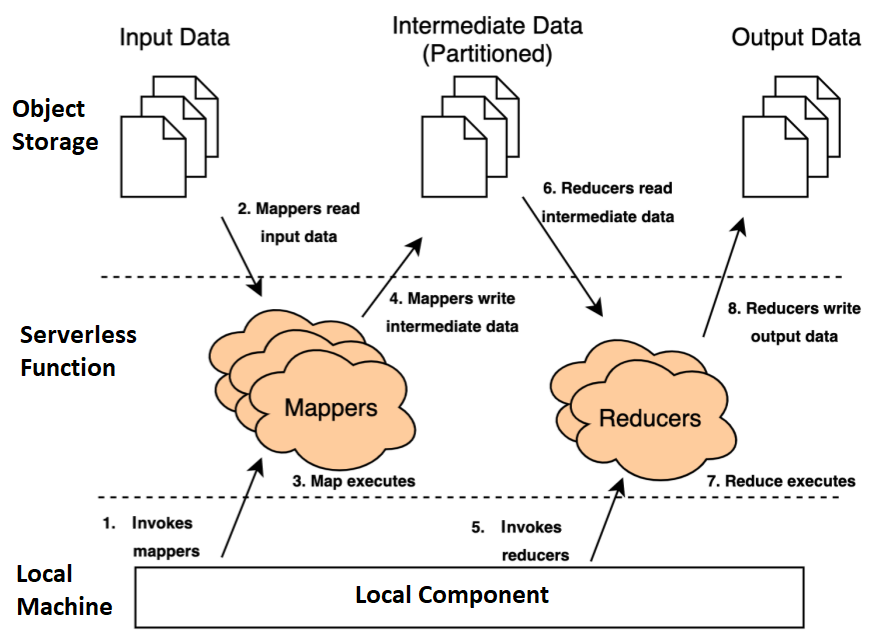

The method uses an Object Storage as the back-end for a stateless shuffle and this Object Storage bucket stores intermediate data that will be later processed by the reducers. It uses the prefixes of Object Storage file/object names to distinguish between files that belong to different partition bins. During the map stage, key/value pairs emitted are written to intermediate files. Keys are partitioned into n bins where n is the number of reducers and each bin is processed by one reducer. Hence one mapper can write as many as n different intermediate files, each representing one bin and containing keys that belong to that bin.

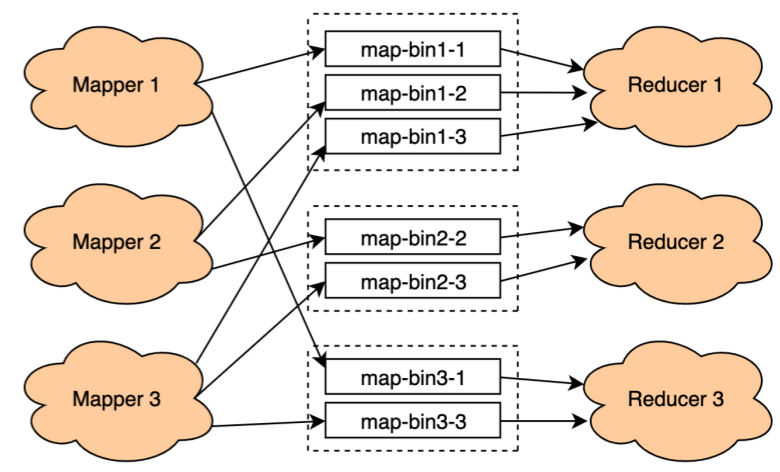

This method is suitable for data-intensive but computational inexpensive tasks. However, it does have limitations: it can only process standard simple map reduce jobs, it's not possible to chain map and reduce phases (no complex map reduce jobs), since there's a component running on a local machine it is subject to becoming a bottleneck of the entire system since it has to coordinate the transition from the map stage to the reduce stage, the component also has to be available during the entire job execution.

<br><br>
**3. Can you make serverless shuffle?**


The map stage partitions data according to the number of reducers and each reducer reads the corresponding data partitions from the all the mappers. Given $M$ mappers and $R$ reducers we will have $M\times R$ intermediate data partitions. Unfortunately, the time and resource limitations imposed by the serverless infrastructures make the implementation of the shuffle operation highly challenging.

A direct approach to implementing shuffles would be to open connections between serverless workers and transfer data directly between them. However, there are two limitations that prevent this approach. First cloud providers do not provide any guarantees on when functions are executed and hence the sender and receiver workers might not be executing at the same time. Second, even if the sender and receiver overlap, given the execution time limit, there might not be enough time to transfer all the necessary data. **A natural approach to transferring data between ephemeral workers is to store intermediate data in a persistent storage system.**


<br><br><br><br>
Good Luck :)